# Plotting sea ice in the Southern Ocean
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4 as nc
import xarray as xr
import numpy as np
import datetime as dt
import os
import calendar
from dask.distributed import Client

The following modules are used in map creation.

In [2]:
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import glob                                       # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps

## Accessing model outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [ ]:
client = Client(n_workers = 4)

Access the default database of experiments from where data will be loaded.

In [3]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

In [4]:
#Saving name of experiments of interest in variables that can be easily referred to
#expv140 = "01deg_jra55v140_iaf"
expv140_c2 = "01deg_jra55v140_iaf_cycle2"

### Experiment variables
You can query the temporal frequency of all variables available in the experiment using `cc.querying.get_frequencies(session, experiment)`. A list of experiment variables can be obtained using `cc.querying.get_variables(session, experiment, frequency)`.

In [ ]:
#Activate the lines below to query temporal frequency
#cc.querying.get_frequencies(session, expv140)

Asking for user input to query experiment variable list

In [6]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, expv140, frequency = "1 monthly")

#Extract variables with keywords included in its long_name column
expvar[expvar["long_name"].str.lower().str.match(".*ice.*")] #force all letters to be lowercase to get matches

NameError: name 'expv140' is not defined

In [ ]:
#Deleting variables no longer in use
del expvar

## Accessing outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [75]:
#Name of experiment(s)
#expv140
expv140_c2
#Name (short name) of variable of interest as identified in previous step
varInt = "aice_m" #monthly ice concentration

Optional variables, activate if needed. Note that because times need correction, **the start time is actually one month after the month we are interested in**. See below for explanation.

In [68]:
#The below variables are optional, activate as needed
#Date from when data should be extracted - Can be given as full date (e.g., 2010-01-01), just year and month, or just year
stime = '2010-02'
#End date from data extraction
etime = '2012-01'

Loading data using `cc.querying.getvar()`. Initially inspecting monthly variables as it is not possible to load more than 5 years of daily data. Daily data will be extracted for period of times when large changes in the variable being inspected are identified.

In [69]:
vararray = cc.querying.getvar(expv140_c2, varInt, session, frequency = '1 monthly', start_time = stime, end_time = etime)
vararray

<xarray.DataArray 'aice_m' (time: 24, nj: 2700, ni: 3600)>
dask.array<concatenate, shape=(24, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2010-02-01 00:00:00 ... 2012-01-01 00:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Data manipulation

**Times need to be corrected** because the time 00:00:00 is interpreted differently by the CICE model. For example, CICE links *2010-01-01 00:00:00* to the start of 2010-01-01, while xarray interprets it as the start of the day after. To fix this problem, 12 hours are subtracted from the time dimension (also known as *time coordinate*).

In [72]:
vararray['time'] = vararray.time - dt.timedelta(hours = 12)

The `aice_m` variable gives the mean monthly concentration of ice in a cell. In other words, this represents the monthly mean proportion of ice found in a given grid cell. To calculate the area covered by ice, the area of each cell is needed.  
The area is saved as `area_t` and it is given by the ocean model, below we will load it to the notebook and multiply it by `aice_m` to get the total ice area.

In [73]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = cc.querying.getvar(expv140_c2, 'area_t', session, n = 1) #ncfile = 'iceh.2010-01.nc') - A ncfile name can be specified

#.coords extracts the values of the specified coordinate
vararray.coords['ni'] = IceArea['xt_ocean'].values
vararray.coords['nj'] = IceArea['yt_ocean'].values

#Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

#Calculate ice area
SOSIarea = vararray*IceArea

Since we are only interested in ice cover in the **Southern Ocean**, a subset of `vararray` and `SOSIarea` will be created. The **Southern Ocean** is defined as ocean waters south of 45S.

In [75]:
#Subsetting sea ice concentration array
SOarr = vararray.sel(yt_ocean = slice(-90, -45))
SOarr

#Subsetting sea ice area array
SOSIarea = SOSIarea.sel(yt_ocean = slice(-90, -45))
SOSIarea

<xarray.DataArray (time: 24, yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(24, 740, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2010-01-31 12:00:00 ... 2011-12-31 12:00:00
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04

In [53]:
#Remove variables no longer in use
del IceArea, stime, etime, vararray

## Data visualisation
A variety of plots showing sea ice area changes in the Southern Ocean will be created below.

**Total sea ice area timeseries plot**

In [65]:
np.floor(np.log10(max(ax.get_yticks()))).astype(int)

-1

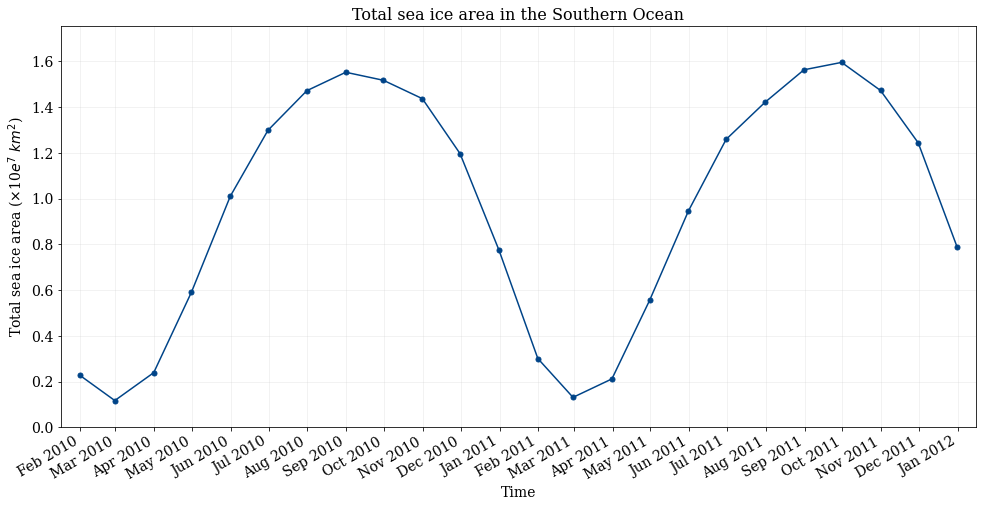

In [80]:
#The sum of sea ice area will be calculated along all longitudes and latitudes
TotalSI = SOSIarea.sum('xt_ocean').sum('yt_ocean')

#Extracting dates information and turning them into pandas datetimes
Dates = TotalSI.indexes['time'].to_datetimeindex()

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Extract information about the plot (figure and axes)
fig, ax = plt.subplots(figsize = (16.4, 8.2))
#Using Dates information to plot dates. Transforming area units from m2 to km2.
ax.plot(Dates, TotalSI.values*1e-6, 
        #Line and and point plot. Changing color
        linestyle = '-', color = "#004488", marker = 'o', markersize = 5)

#Adding a main title to the plot - Increasing font size
plt.title('Total sea ice area in the Southern Ocean', fontsize = 16)

#Changing y axes
#Calculating the exponent of scientific notation in the y axis
exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
#The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
#include more than one character in an expression
plt.ylabel(r'Total sea ice area ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
#Changing the limits of the y axis. Max value is 10% more than maximum value in the data
plt.ylim(0, np.floor(max(TotalSI).values*1e-6*1.1))
#Removing the scientific notation from the top of the graph as it is already included in the y label
ax.yaxis.get_offset_text().set_visible(False)

#Changing x axis
#Change axes labels
plt.xlabel('Time')
#Extract min and max dates
datemin = min(Dates) - dt.timedelta(days = 15)
datemax = max(Dates) + dt.timedelta(days = 15)
#Setting x axis limits
ax.set_xlim(datemin, datemax)
#Change ticks and label position
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
#Change the format of the dates shown (month abbreviation and year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
#Rotating the x axis labels to avoid label overlapping
fig.autofmt_xdate()

#Set major gridlines to appear, but with high transparency
ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2)

#Save figure to local folder
plt.savefig("../Outputs/Figures/TimeSeriesSeaIce.tiff", dpi = 300)

In [15]:
#Remove variables no longer in use
del datemax, datemin, exp_yaxis, TotalSI

**Mean monthly sea ice area**

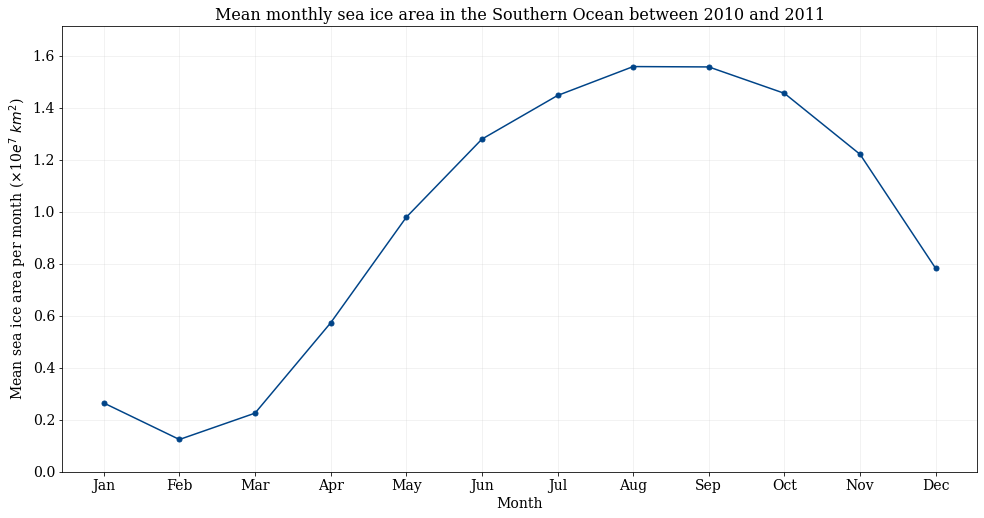

In [81]:
#The sum of sea ice area will be calculated along all longitudes and latitudes
MonMSI = SOSIarea.groupby('time.month').mean('time').sum('xt_ocean').sum('yt_ocean')
#Extracting months (in numbers) and changing to month abbreviation
Months = [calendar.month_abbr[m] for m in MonMSI.month.values]

#Extracting maximum and minimum year information
MinY = min(SOSIarea.indexes['time'].to_datetimeindex().year)
MaxY = max(SOSIarea.indexes['time'].to_datetimeindex().year)

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Extract information about the plot (figure and axes)
#Figure size set to 8.2" wide and 4.1" tall (fits across A4)
fig, ax = plt.subplots(figsize = (16.4, 8.2))
#Using Dates information to plot dates. Transforming area units from m2 to km2.
ax.plot(Months, MonMSI.values*1e-6, 
        #Line and and point plot. Changing color
        linestyle = '-', color = "#004488", marker = 'o', markersize = 5)

#Adding a main title to the plot - Increasing font size
plt.title('Mean monthly sea ice area in the Southern Ocean between {} and {}'.format(MinY, MaxY), 
          fontsize = 16)

#Changing y axes
#Calculating the exponent of scientific notation in the y axis
exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
#The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
#include more than one character in an expression
plt.ylabel(r'Mean sea ice area per month ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
#Changing the limits of the y axis. Max value is 10% more than maximum value in the data
plt.ylim(0, np.floor(max(MonMSI).values*1e-6*1.1))
# #Removing the scientific notation from the top of the graph as it is already included in the y label
ax.yaxis.get_offset_text().set_visible(False)

#Changing x axis
#Change axes labels
plt.xlabel('Month')

#Set major gridlines to appear, but with high transparency
ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2)

#Save figure to local folder
plt.savefig("../Outputs/Figures/MonthlyMeanSeaIce.tiff", dpi = 300)

#Automated path
# os.path.join('../Outputs/Figures', ('MonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.tiff'))

In [18]:
#Remove variables no longer in use
del Months, MaxY, MinY, MonMSI

In [ ]:
# import copy
# x = copy.deepcopy(SeasonSI)
# np.nansum(x.values)
#38203630000000.0
# x = x*1e-6
# 38203640.0
np.nansum(x.sel(season = "DJF").values*1e6)
# 3.9014373

**Map showing mean seasonal sea ice area**

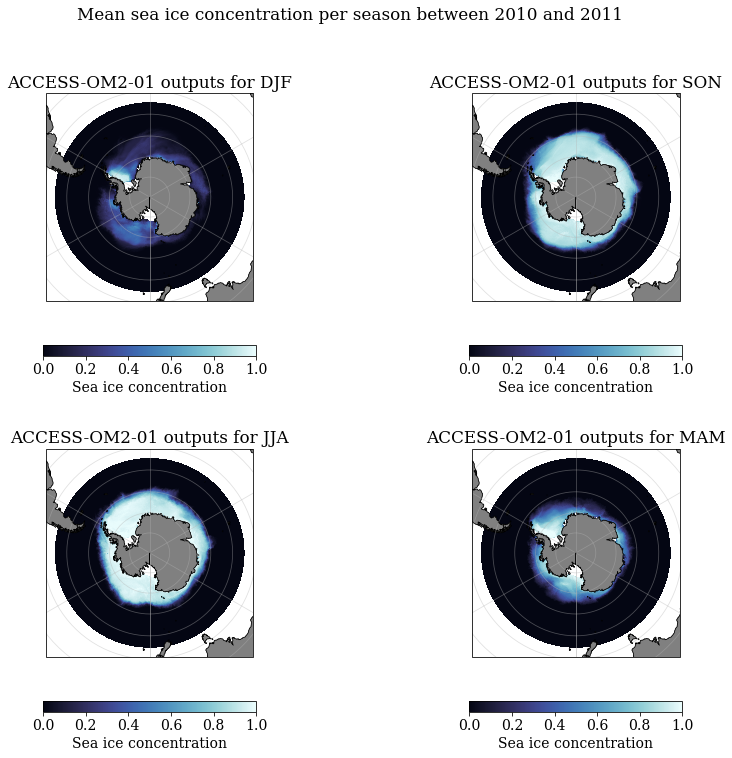

In [107]:
#The sum of sea ice area will be calculated along all longitudes and latitudes
SeasonSI = SOarr.groupby('time.season').mean('time')

#Extracting maximum and minimum year information
MinY = min(SOarr.indexes['time'].to_datetimeindex().year)
MaxY = max(SOarr.indexes['time'].to_datetimeindex().year)

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Create composite figures
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 12), 
                         subplot_kw = dict(projection = projection))
#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (1, 1, 'MAM'), (1, 0, 'JJA'), (0, 1, 'SON')]:
    #Extract information for each season and start plotting
    #pcolormesh creates a pseudo color map with a non-rectangular grid
    p1 = SeasonSI.sel(season = season).plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                                                       #Setting color palette and min-max values for colourbar
                                                       cmap = cm.cm.ice, vmin = 0, vmax = 1, 
                                                       #Remove colourbar to allow for further manipulation
                                                       transform = ccrs.PlateCarree(), add_colorbar = False)
    #Set title for each subplot and remove x and y axes labels
    axes[i,j].set_title('ACCESS-OM2-01 outputs for ' + season)
    axes[i,j].set_ylabel("")
    axes[i,j].set_xlabel("")
    
    #Change the colourbars for each figure
    cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.6)
    #Set title for colourbar
    cb.ax.set_xlabel('Sea ice concentration')

#Changing global parameters
for ax in axes.flat:
    ax.coastlines(resolution = '50m')
    ax.add_feature(land_50m)
    ax.gridlines(color = "#b4b4b4", alpha = 0.4)

#Removes white space
plt.tight_layout()
#Set title for composite figure
fig.suptitle('Mean sea ice concentration per season between ' + str(MinY) + ' and '+ str(MaxY))

#Save figure to local folder
plt.savefig("../Outputs/Figures/SeasonalMeanSeaIce.tiff", dpi = 300)

In [109]:
%who

Client	 Dates	 IceArea	 OrderedDict	 SOarr	 TotalSI	 ax	 cc	 ccrs	 
cft	 cftime	 cm	 datemax	 datemin	 dt	 etime	 exp_yaxis	 expv140_c2	 
fig	 glob	 math	 mdates	 nc	 np	 os	 pd	 plt	 
session	 stime	 varInt	 vararray	 xr	 
